In [3]:
import gudhi as gd
from gudhi import representations
import numpy as np
import numpy.random
from numpy import linalg
import matplotlib.pyplot as plt
import pingouin as pg
import scipy.stats as st
from collections import defaultdict
from bifiltration_utils import difference_ECP
import purepyECP as pure


In [4]:
import scipy
scipy.__version__

'1.7.3'

In [19]:
def get_ecp(data, EPS):
    ecps = []
    for dat in data:
        filt = pure.gaussian_density(dat.reshape(-1,1), sigma =1)
        contrib, n_simplices = pure.compute_local_contributions(dat.reshape(-1,1), EPS, filt)
        ecps.append(contrib)
    return ecps

In [5]:
def ecp_distance_matrix(ECCs1, ECCs2, f1max, f2max):
    dists = np.zeros((len(ECCs1), len(ECCs2)))
    if (ECCs1 == ECCs2):
        for i in range(0,len(ECCs1)):
            for j in range(0,i):
                #print(ECCs1[i], ECCs2[j])
                dists[i][j] = difference_ECP(ECCs1[i], ECCs2[j], (0,f1max, 0, f2max))
            
        dists = dists + dists.T
    else:
        for i in range(0,len(ECCs1)):
            for j in range(0,len(ECCs2)):
                dists[i][j] = difference_ECP(ECCs1[i], ECCs2[j], (0,f1max, 0, f2max))
    return dists

In [8]:
def train_statistics(RV, N, n_samples, n_samples_test, q=0.95):
    samples = [RV.rvs(N) for i in range(n_samples)]
    #if standarize_data:
    samples_std = [standarize(sample) for sample in samples]
    samples = samples_std.copy()
    
    eccs = get_ecp(samples, 1)
    
    W1_train = ecp_distance_matrix(eccs, eccs, 4, 0.1)

    samples_test = [RV.rvs(N) for i in range(n_samples_test)]
    #if standarize_data:
    samples_test_std = [standarize(sample) for sample in samples_test]
    samples_test = samples_test_std.copy()
    
    eccs_test = get_ecp(samples_test, 1)
    W1_test = ecp_distance_matrix(eccs, eccs_test, 4, 0.1)

    dmean = np.mean(W1_test, axis=1)
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1)
    qmean = np.quantile(dmean, q)
    qmin = np.quantile(dmin, q)
    qmax = np.quantile(dmax, q)
    qq = np.quantile(dq, q)
    return eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq

In [21]:
def standarize(X):
    return (X-np.mean(X))/np.std(X)

def topo_test(samples, eccs, qmin, qmean, qmax, qq):
    #if standarize_data:
    samples_std = [standarize(sample) for sample in samples]
    samples = samples_std.copy()
    
    #print("topo_test before ecc")
    eccs_test = get_ecp(samples, 1)
    #print("topo_test: got eccs, now compute distances")
    W1_test = ecp_distance_matrix(eccs, eccs_test, 4, 0.1)
    #print("topo_test: distances computed")
    dmin = np.min(W1_test, axis=1)
    dmax = np.max(W1_test, axis=1)
    dmean = np.mean(W1_test, axis=1)
    dq = np.quantile(W1_test, q=0.9, axis=1) # takie samo q jak w train_statistcs
    
    is_normal_min = dmin < qmin
    is_normal_mean = dmean < qmean
    is_normal_max = dmax < qmax
    is_normal_q = dq < qq
    
    p_empirical_min = np.sum(is_normal_min)/len(is_normal_min)
    p_empirical_mean = np.sum(is_normal_mean)/len(is_normal_mean)
    p_empirical_max = np.sum(is_normal_max)/len(is_normal_max)
    p_empirical_q = np.sum(is_normal_q)/len(is_normal_q)
    #print("topo_test done")
    return p_empirical_min, p_empirical_mean, p_empirical_max, p_empirical_q

def normality_tests(samples):
    def anderson(sample):
        anderson_out = st.anderson(sample, 'norm')
        return anderson_out.statistic < anderson_out.critical_values[2]

    shapiro = [st.shapiro(sample).pvalue >0.05 for sample in samples]
    ks = [st.kstest(sample, 'norm').pvalue >0.05 for sample in samples]
    cvm = [st.cramervonmises(sample, 'norm').pvalue >0.05 for sample in samples]
    ad = [anderson(sample) for sample in samples]
    
    shapiro = np.sum(shapiro)/len(shapiro)
    ks = np.sum(ks)/len(ks)
    ad = np.sum(ad)/len(ad)
    cvm = np.sum(cvm)/len(cvm)
    return shapiro, ks, ad, cvm

In [13]:
# generate other distributions to measure test power
# first check normal distribution
def empirical_test_power(RV, eccs, qmin, qmean, qmax, qq, N=100, n_samples=250):
    samples_topo = [RV.rvs(N) for i in range(n_samples)]
    mu = RV.stats('m')
    std = np.sqrt(RV.stats('v'))
    samples = [(sample-mu)/std for sample in samples_topo]
    #print("in empirical_test_power, after standardizing")
    topo_min, topo_mean, topo_max, topo_q = topo_test(samples_topo, eccs, qmin, qmean, qmax, qq)
    #print("in empirical_test_power, after topo_test")
    power_shapiro, power_ks, power_ad, power_cvm = normality_tests(samples)
    #print("done with empirical_test_power")
    return topo_min, topo_mean, topo_max, topo_q, power_shapiro, power_ks, power_ad, power_cvm

In [17]:
# https://www.semanticscholar.org/paper/Power-comparisons-of-Shapiro-Wilk-%2C-%2C-Lilliefors-Razali-Wah/dcdc0a0be7d65257c4e6a9117f69e246fb227423

rv_normal = st.norm()
rv_normal2_2 = st.norm(2,2)
rv_beta2_2 = st.beta(2, 2)
rv_beta5_5 = st.beta(5, 5)
rv_beta10_10 = st.beta(10, 10)
rv_laplace = st.laplace()
rv_uniform = st.uniform()
rv_t3 = st.t(df=3)
rv_t5 = st.t(df=5)
rv_t7 = st.t(df=7)
rv_t10 = st.t(df=10)
rv_gamma10_1 = st.gamma(10,1)
rv_gamma20_1 = st.gamma(20,1)
rv_gamma4_5 = st.gamma(4,5)
rv_chisq4 = st.chi2(df=4)
rv_chisq10 = st.chi2(df=10)
rv_lorentz = st.cauchy()

wasserstein_p = 1
wasserstein_order = 1
standarize_data = True

outputfilename = f'results/{standarize_data}_distrib_std_ECP'

rvs = [rv_normal, rv_normal2_2, rv_beta2_2, rv_beta5_5, rv_beta10_10, rv_laplace, rv_uniform, rv_t3, rv_t5, rv_t7, rv_t10, 
       rv_gamma10_1, rv_gamma20_1, rv_gamma4_5, rv_chisq4, rv_chisq10, rv_lorentz]
rv_names = ['Normal01', 'Normal22', 'Beta22', 'Beta55', 'Beta1010', 'Laplace', 'Uniform', 't3', 't5', 't7', 't10', 
            'G10_1', 'G20_1', 'G4_5', 'ChiSq4', 'ChiSq10']    

In [20]:
n_samples = 500
mc_loops = 750
results = defaultdict(list)
resuts_stats = {}

for N in [30, 50, 100, 150, 200]:#, 250, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # compute the  distance matrix for normal distribution for given data size N
    eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq = train_statistics(rv_normal, N=N, n_samples=n_samples, n_samples_test=750, q=0.95)
    resuts_stats[N] = [eccs, qmin, qmean, qmax, qq, dmin, dmean, dmax, dq]
    
    for rv, rv_name in zip(rvs, rv_names):
        print(f'N={N} rv_name={rv_name}')
        results[rv_name].append([N, *empirical_test_power(RV=rv, eccs=eccs, qmin=qmin, qmean=qmean, qmax=qmax, qq=qq, N=N, n_samples=mc_loops)])
    
    np.save(outputfilename+'ECP.npy', results)
    np.save(outputfilename+'ECP_stats.npy', resuts_stats)

N=30 rv_name=Normal01


NameError: name 'ecc_distance_matrix' is not defined

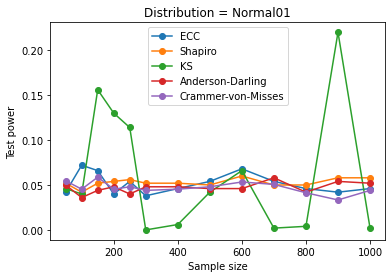

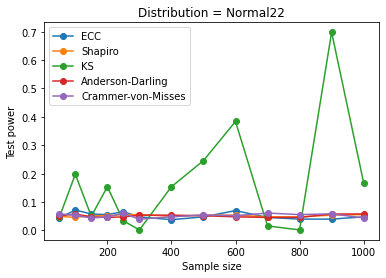

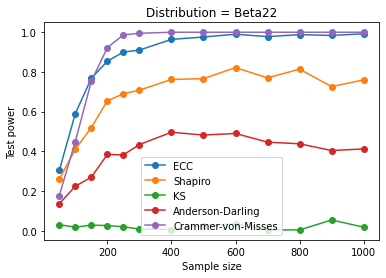

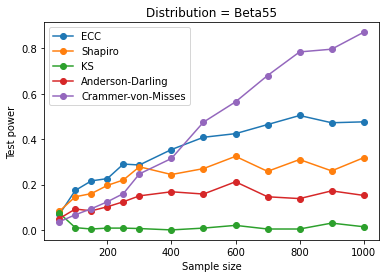

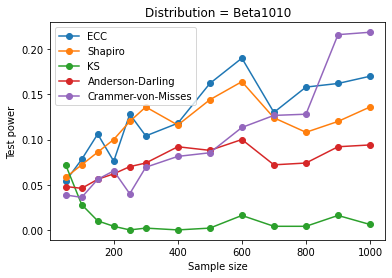

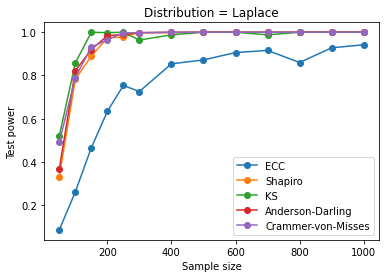

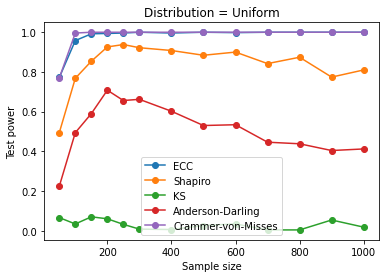

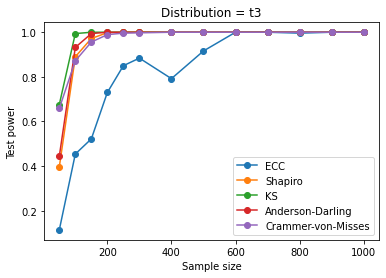

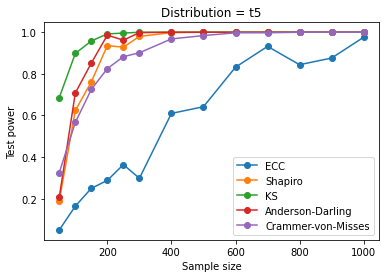

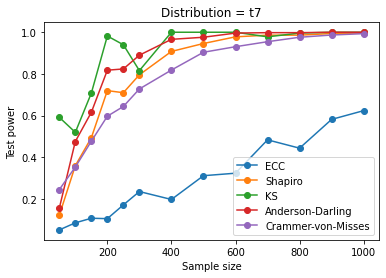

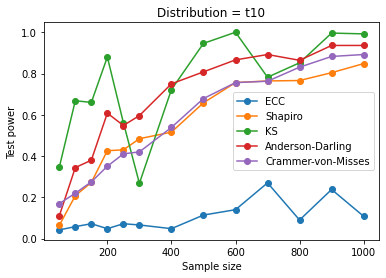

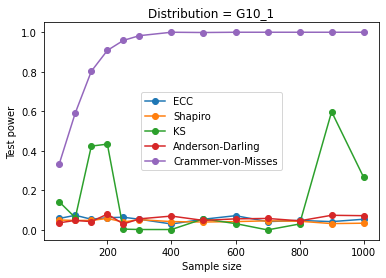

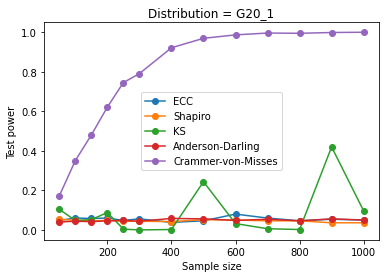

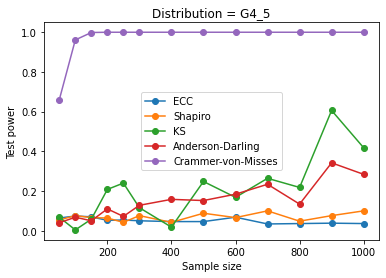

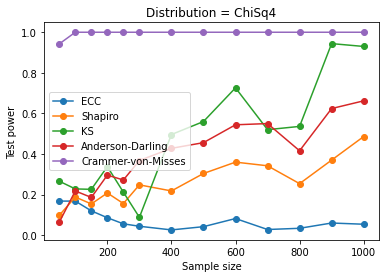

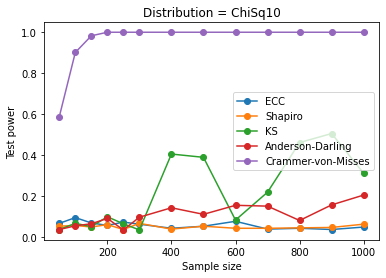

In [36]:
for dist_name in results.keys():
    data = results[dist_name]
    data = np.array(data)
    plt.plot(data[:, 0], 1-data[:, 1], 'o-', label='ECP')
    plt.plot(data[:, 0], 1-data[:, 2], 'o-', label='Shapiro')
    plt.plot(data[:, 0], 1-data[:, 3], 'o-', label='KS')
    plt.plot(data[:, 0], 1-data[:, 4], 'o-', label='Anderson-Darling')
    plt.plot(data[:, 0], 1-data[:, 5], 'o-', label='Crammer-von-Misses')
    plt.xlabel('Sample size')
    plt.ylabel('Test power')
    plt.title(f'Distribution = {dist_name}')
    plt.legend()
    plt.savefig(outputfilename+'_'+dist_name+'_ECP.png')
    plt.show()